In [7]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')

In [10]:
sns.set()
%matplotlib inline

In [11]:
%%time
warnings.simplefilter('ignore')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.5 µs


In [17]:
files = ['./input/test_identity.csv', 
         './input/test_transaction.csv',
         './input/train_identity.csv',
         './input/train_transaction.csv',
         './input/sample_submission.csv']

In [18]:
#可以对数据进行压缩，从而减少内存消耗
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
def load_data(file):
    return reduce_mem_usage(pd.read_csv(file))

In [20]:
with multiprocessing.Pool() as pool:
    test_identity, test_transaction, train_identity, train_transaction, sample_submission = pool.map(load_data, files)

Mem. usage decreased to  2.90 Mb (62.5% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)


In [21]:
train_transaction.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
train_transaction.describe().T.assign(missing_rate = train_transaction.apply(lambda x:(len(x)-x.count())/len(x)))

,count,mean,std,min,25%,50%,75%,max,missing_rate
TransactionID,590540.0,3.282270e+06,1.704744e+05,2.987000e+06,3.134635e+06,3282269.50,3.429904e+06,3577539.0,0.000000
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000000e+00,0.000000e+00,0.00,0.000000e+00,1.0,0.000000
TransactionDT,590540.0,7.372311e+06,4.617224e+06,8.640000e+04,3.027058e+06,7306527.50,1.124662e+07,15811131.0,0.000000
TransactionAmt,590540.0,NaN,NaN,2.509766e-01,4.331250e+01,68.75,1.250000e+02,31936.0,0.000000
card1,590540.0,9.898735e+03,4.901170e+03,1.000000e+03,6.019000e+03,9678.00,1.418400e+04,18396.0,0.000000
card2,581607.0,NaN,NaN,1.000000e+02,2.140000e+02,361.00,5.120000e+02,600.0,0.015127
card3,588975.0,NaN,0.000000e+00,1.000000e+02,1.500000e+02,150.00,1.500000e+02,231.0,0.002650
card5,586281.0,NaN,0.000000e+00,1.000000e+02,1.660000e+02,226.00,2.260000e+02,237.0,0.007212
addr1,524834.0,NaN,NaN,1.000000e+02,2.040000e+02,299.00,3.300000e+02,540.0,0.111264
addr2,524834.0,NaN,0.000000e+00,1.000000e+01,8.700000e+01,87.00,8.700000e+01,102.0,0.111264


In [23]:
train_transaction['TransactionAmt'] = train_transaction['TransactionAmt'].astype(float)

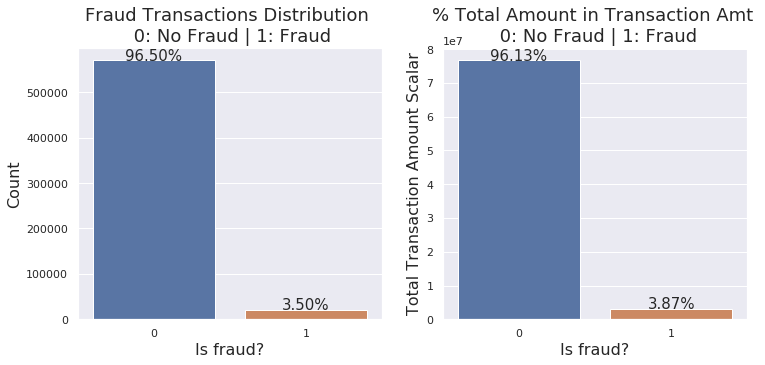

In [24]:
total = len(train_transaction)
total_amt = train_transaction.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(12,5))
plt.subplot(121)
plot_tr = sns.countplot(x='isFraud', data=train_transaction)
plot_tr.set_title("Fraud Transactions Distribution \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr.set_xlabel("Is fraud?", fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
    
percent_amt = (train_transaction.groupby(['isFraud'])['TransactionAmt'].sum())
percent_amt = percent_amt.reset_index()
plt.subplot(122)
plot_tr_2 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=percent_amt)
plot_tr_2.set_title("% Total Amount in Transaction Amt \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr_2.set_xlabel("Is fraud?", fontsize=16)
plot_tr_2.set_ylabel('Total Transaction Amount Scalar', fontsize=16)
for p in plot_tr_2.patches:
    height = p.get_height()
    plot_tr_2.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15)     

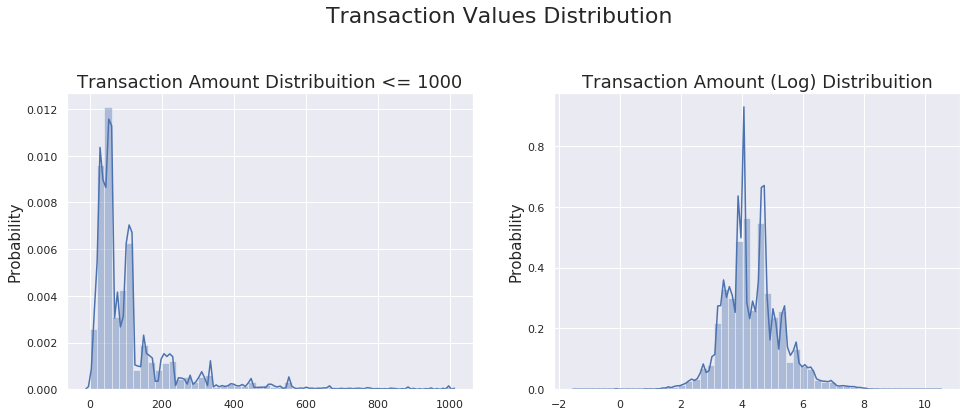

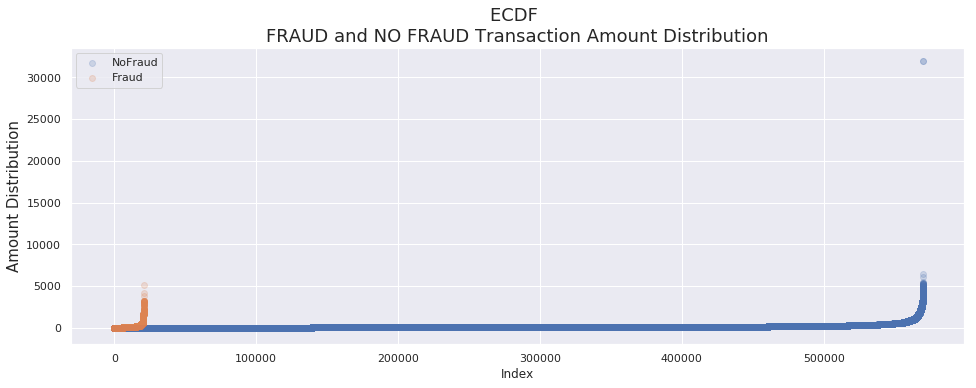

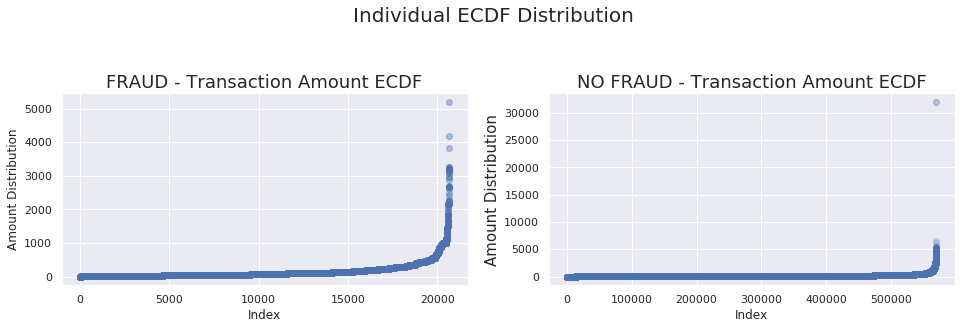

In [25]:
#Ploting Transaction Amount Values Distribution
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
sub_plot_1 = sns.distplot(train_transaction[train_transaction['TransactionAmt'] <= 1000]['TransactionAmt'])
sub_plot_1.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
sub_plot_1.set_xlabel("")
sub_plot_1.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
sub_plot_2 = sns.distplot(np.log(train_transaction['TransactionAmt']))
sub_plot_2.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
sub_plot_2.set_xlabel("")
sub_plot_2.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))

plt.subplot(212)
sub_plot_3 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
sub_plot_3 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2)
sub_plot_3= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
sub_plot_3 = plt.xlabel("Index")
sub_plot_3 = plt.ylabel("Amount Distribution", fontsize=15)
sub_plot_3 = plt.legend()

plt.figure(figsize=(16,12))

plt.subplot(321)
sub_plot_4 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]), 
                 np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
sub_plot_5 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
sub_plot_5 = plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
sub_plot_5 = plt.xlabel("Index")
sub_plot_5 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=20)

plt.show()

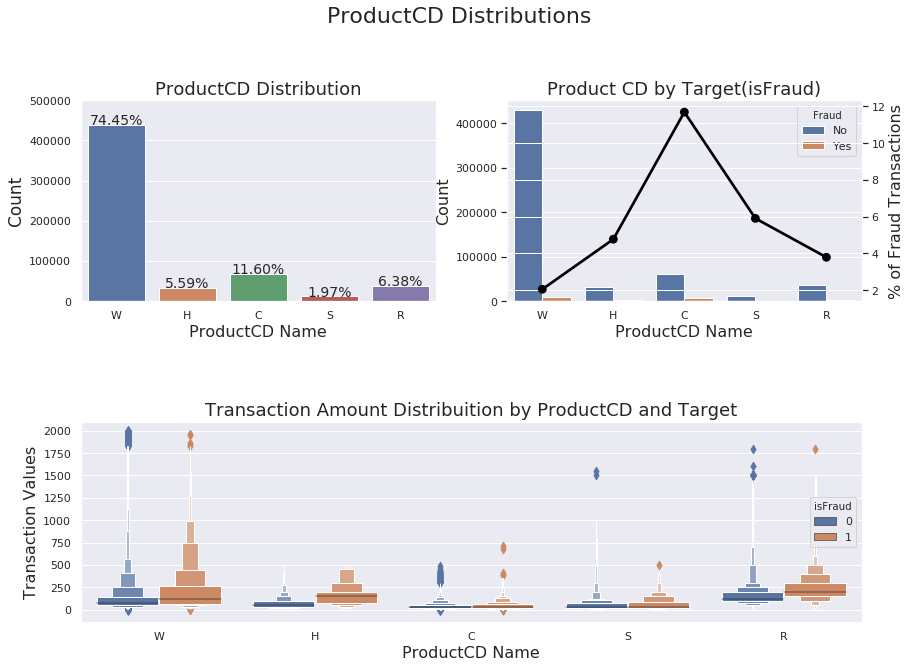

In [26]:
#The Product Feature
tmp = pd.crosstab(train_transaction['ProductCD'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='ProductCD', data=train_transaction)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

plot_1.set_title("ProductCD Distribution", fontsize=18)
plot_1.set_xlabel("ProductCD Name", fontsize=16)
plot_1.set_ylabel("Count", fontsize=17)
plot_1.set_ylim(0,500000)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
                height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14)
    
plt.subplot(222)
plot_2 = sns.countplot(x='ProductCD', hue='isFraud', data=train_transaction)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_2.twinx()
plot_2_2 = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)

plot_2.set_title("Product CD by Target(isFraud)", fontsize=18)
plot_2.set_xlabel("ProductCD Name", fontsize=16)
plot_2.set_ylabel("Count", fontsize=16)

plt.subplot(212)
plot_3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
plot_3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=18)
plot_3.set_xlabel("ProductCD Name", fontsize=16)
plot_3.set_ylabel("Transaction Values", fontsize=16)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [27]:
#Visualizing Card 1, Card 2 and Card 3 Distributions
train_transaction.loc[train_transaction.card3.isin(train_transaction.card3.value_counts()[train_transaction.card3.value_counts() < 200].index), 'card3'] = "Others"
train_transaction.loc[train_transaction.card5.isin(train_transaction.card5.value_counts()[train_transaction.card5.value_counts() < 300].index), 'card5'] = "Others"

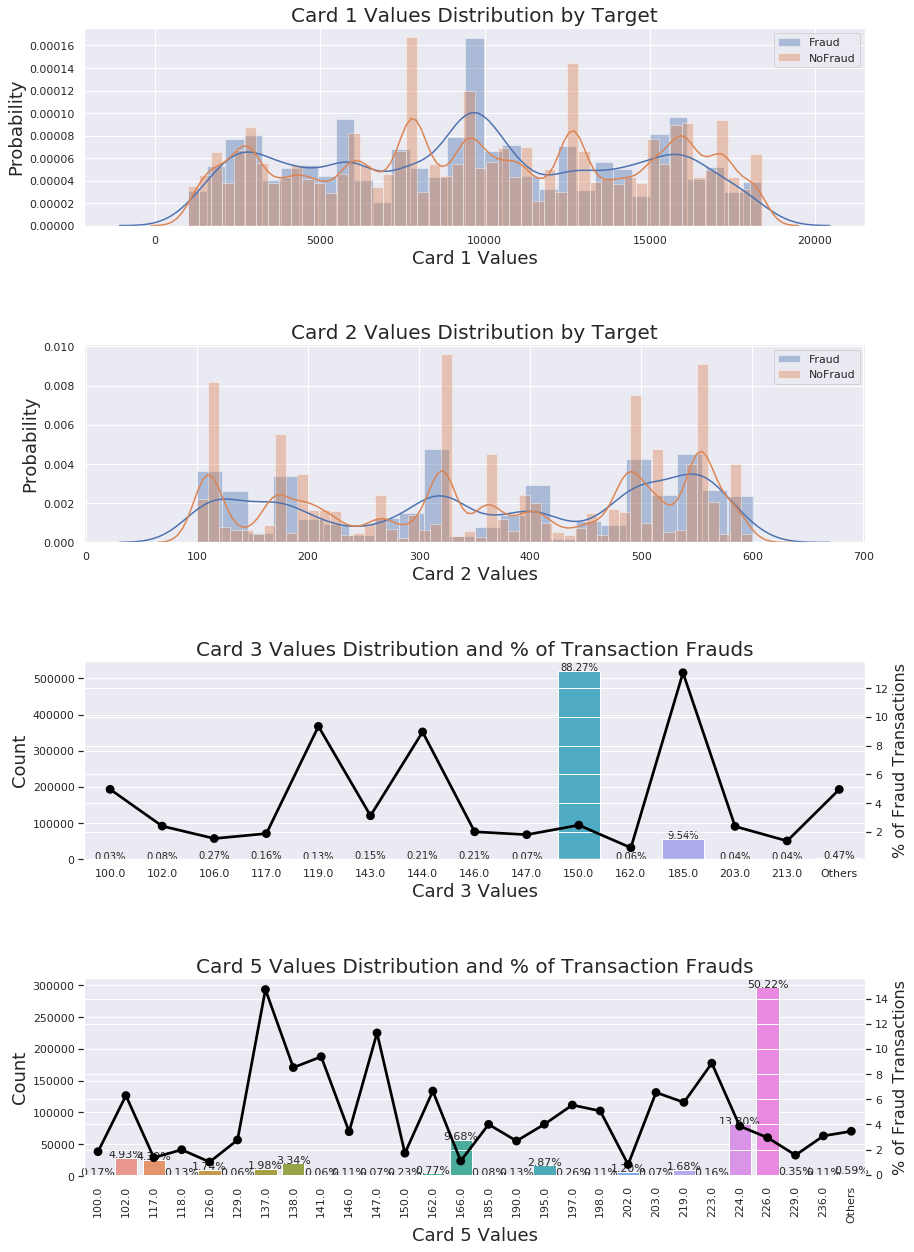

In [28]:
tmp = pd.crosstab(train_transaction['card3'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(train_transaction['card5'], train_transaction['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
plot_1 = sns.distplot(train_transaction[train_transaction['isFraud'] == 1]['card1'], label='Fraud')
plot_1 = sns.distplot(train_transaction[train_transaction['isFraud'] == 0]['card1'], label='NoFraud')
plot_1.legend()
plot_1.set_title("Card 1 Values Distribution by Target", fontsize=20)
plot_1.set_xlabel("Card 1 Values", fontsize=18)
plot_1.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
plot_2 = sns.distplot(train_transaction[train_transaction['isFraud'] == 1]['card2'].dropna(), label='Fraud')
plot_2 = sns.distplot(train_transaction[train_transaction['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
plot_2.legend()
plot_2.set_title("Card 2 Values Distribution by Target", fontsize=20)
plot_2.set_xlabel("Card 2 Values", fontsize=18)
plot_2.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
plot_3 = sns.countplot(x='card3', data=train_transaction, order=list(tmp.card3.values))
plot_3_2 = plot_3.twinx()
plot_3_2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
plot_3_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_3.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
plot_3.set_xlabel("Card 3 Values", fontsize=18)
plot_3.set_ylabel("Count", fontsize=18)
for p in plot_3.patches:
    height = p.get_height()
    plot_3.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
plot_4 = sns.countplot(x='card5', data=train_transaction, order=list(tmp2.card5.values))
plot_4_2 = plot_4.twinx()
plot_4_2 = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
plot_4_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_4.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
plot_4.set_xticklabels(plot_4.get_xticklabels(),rotation=90)
plot_4.set_xlabel("Card 5 Values", fontsize=18)
plot_4.set_ylabel("Count", fontsize=18)
for p in plot_4.patches:
    height = p.get_height()
    plot_4.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

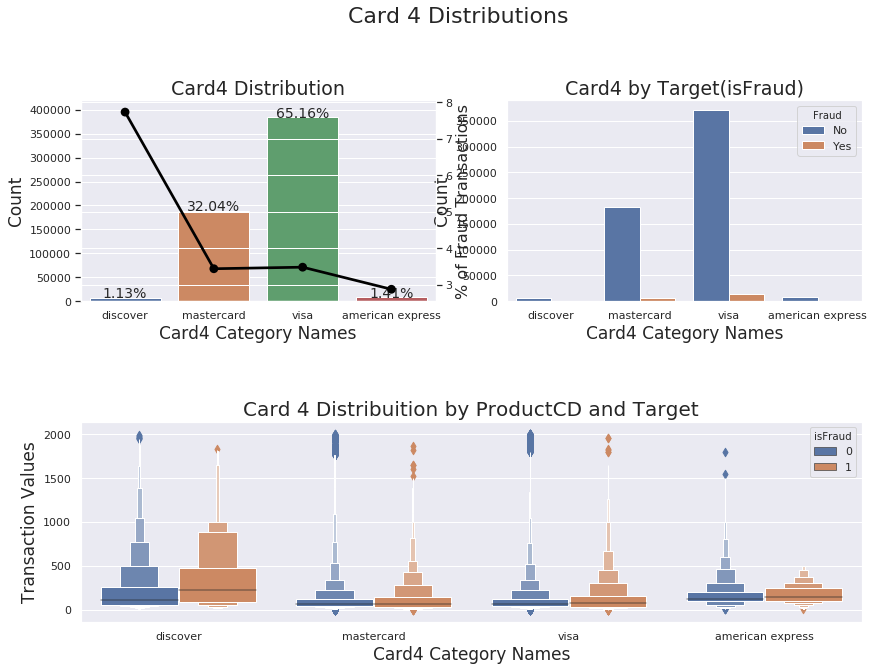

In [29]:
#Card 4 - Categorical Feature
tmp = pd.crosstab(train_transaction['card4'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='card4', data=train_transaction)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
plot_1.set_title("Card4 Distribution", fontsize=19)
plot_1.set_ylim(0,420000)
plot_1.set_xlabel("Card4 Category Names", fontsize=17)
plot_1.set_ylabel("Count", fontsize=17)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
plot_2 = sns.countplot(x='card4', hue='isFraud', data=train_transaction)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_1.twinx()
plot_2_2 = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_2.set_title("Card4 by Target(isFraud)", fontsize=19)
plot_2.set_xlabel("Card4 Category Names", fontsize=17)
plot_2.set_ylabel("Count", fontsize=17)

plt.subplot(212)
plot_3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
plot_3.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=20)
plot_3.set_xlabel("Card4 Category Names", fontsize=17)
plot_3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

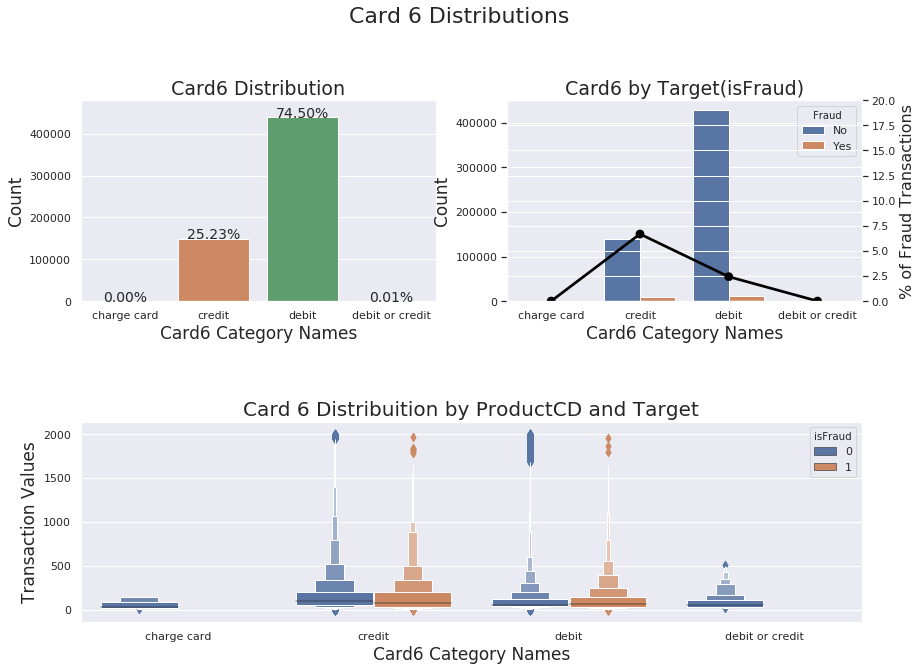

In [30]:
#Card 6 - Categorical
tmp = pd.crosstab(train_transaction['card6'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='card6', data=train_transaction, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
plot_1.set_title("Card6 Distribution", fontsize=19)
plot_1.set_ylim(0,480000)
plot_1.set_xlabel("Card6 Category Names", fontsize=17)
plot_1.set_ylabel("Count", fontsize=17)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
plot_2 = sns.countplot(x='card6', hue='isFraud', data=train_transaction, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_2.twinx()
plot_2_2 = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
plot_2_2.set_ylim(0,20)
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_2.set_title("Card6 by Target(isFraud)", fontsize=19)
plot_2.set_xlabel("Card6 Category Names", fontsize=17)
plot_2.set_ylabel("Count", fontsize=17)

plt.subplot(212)
plot_3 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', order=list(tmp.card6.values),
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
plot_3.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=20)
plot_3.set_xlabel("Card6 Category Names", fontsize=17)
plot_3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [52]:
#Exploring M1-M9 Features
for columns in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    train_transaction[columns] = train_transaction[columns].fillna("Miss")
    
def ploting_dist_ratio(DataFile, Column, lim=2000):
    tmp = pd.crosstab(DataFile[Column], DataFile['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{Column} Distributions',fontsize=22)

    plt.subplot(121)
    plot_1 = sns.countplot(x=Column, data=DataFile, order=list(tmp[Column].values))
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    plot_1.set_title(f"{Column} Distribution\nCound and %Fraud by each category", fontsize=18)
    plot_1.set_ylim(0,400000)
    plot_1_2 = plot_1.twinx()
    plot_1_2 = sns.pointplot(x=Column, y='Fraud', data=tmp, order=list(tmp[Column].values),
                       color='black', legend=False, )
    plot_1_2.set_ylim(0,20)
    plot_1_2.set_ylabel("% of Fraud Transactions", fontsize=16)
    plot_1.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_1.set_ylabel("Count", fontsize=17)
    for p in plot_1_2.patches:
        height = p.get_height()
        plot_1_2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (train_transaction.groupby(['isFraud',Column])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    plot_2 = sns.boxplot(x=Column, y='TransactionAmt', hue='isFraud', 
                     data=DataFile[DataFile['TransactionAmt'] <= lim], order=list(tmp[Column].values))
    plot_2_2 = plot_2.twinx()
    plot_2_2 = sns.pointplot(x=Column, y='Fraud', data=perc_amt, order=list(tmp[Column].values),
                       color='black', legend=False, )
    plot_2_2.set_ylim(0,5)
    plot_2_2.set_ylabel("%Fraud Total Amount", fontsize=16)
    plot_2.set_title(f"{Column} by Transactions dist", fontsize=18)
    plot_2.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_2.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()

SyntaxError: invalid syntax (<ipython-input-52-419f8a0a4e45>, line 11)

In [53]:
for columns in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    ploting_dist_ratio(train_transaction, columns, lim=2500)

NameError: name 'ploting_dist_ratio' is not defined

In [54]:
#Addr1 Distributions
train_transaction.loc[train_transaction.addr1.isin(train_transaction.addr1.value_counts()[train_transaction.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
train_transaction.loc[train_transaction.addr2.isin(train_transaction.addr2.value_counts()[train_transaction.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

In [55]:
def ploting_cnt_amt(DataFile, Column, lim=2000):
    tmp = pd.crosstab(DataFile[Column], DataFile['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{Column} Distributions ', fontsize=24)
    
    plt.subplot(211)
    plot_1 = sns.countplot(x=Column,data=DataFile,order=list(tmp[Column].values))
    plot_1_2 = plot_1.twinx()
    plot_1_2 = sns.pointplot(x=Column, y='Fraud', data=tmp, order=list(tmp[Column].values),
                       color='black', legend=False)
    plot_1_2.set_ylim(0,tmp['Fraud'].max()*1.1)
    plot_1_2.set_ylabel("%Fraud Transactions", fontsize=16)
    plot_1.set_title(f"Most Frequent {Column} values and % Fraud Transactions", fontsize=20)
    plot_1.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_1.set_ylabel("Count", fontsize=17)
    plot_1.set_xticklabels(plot_1.get_xticklabels(),rotation=45)
    sizes = []
    for p in plot_1.patches:
        height = p.get_height()
        sizes.append(height)
        plot_1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    plot_1.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (DataFile.groupby(['isFraud',Column])['TransactionAmt'].sum() \
                / DataFile.groupby([Column])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = DataFile.groupby([Column])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    plot_2 = sns.barplot(x=Column, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[Column].values))
    plot_2_2 = plot_2.twinx()
    plot_2_2 = sns.pointplot(x=Column, y='Fraud', data=perc_amt, 
                        order=list(tmp[Column].values),
                       color='black', legend=False, )
    plot_2_2.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    plot_2_2.set_ylabel("%Fraud Total Amount", fontsize=16)
    plot_2.set_xticklabels(plot_2.get_xticklabels(),rotation=45)
    plot_2.set_title(f"{Column} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    plot_2.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_2.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    plot_2.set_xticklabels(plot_2.get_xticklabels(),rotation=45)    
    
    for p in plot_2.patches:
        height = p.get_height()
        plot_2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    
ploting_cnt_amt(train_transaction, 'addr1')

SyntaxError: invalid syntax (<ipython-input-55-aa1d1e25f399>, line 7)

In [ ]:
# ADDR2 Distributions 
ploting_cnt_amt(train_transaction, 'addr2')

In [ ]:
#Ploting P-Email Domain
train_transaction.loc[train_transaction['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

train_transaction.loc[train_transaction['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
train_transaction.loc[train_transaction['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
train_transaction.loc[train_transaction.P_emaildomain.isin(train_transaction.P_emaildomain\
                                         .value_counts()[train_transaction.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
train_transaction.P_emaildomain.fillna("NoInf", inplace=True)

In [56]:
ploting_cnt_amt(train_transaction, 'R_emaildomain')

NameError: name 'ploting_cnt_amt' is not defined

In [57]:
#Exploring C1-C14 features
train_transaction.loc[train_transaction.C1.isin(train_transaction.C1\
                              .value_counts()[train_transaction.C1.value_counts() <= 400 ]\
                              .index), 'C1'] = "Others"

In [58]:
ploting_cnt_amt(train_transaction, 'C1')

NameError: name 'ploting_cnt_amt' is not defined

In [59]:
train_transaction.loc[train_transaction.C2.isin(train_transaction.C2\
                              .value_counts()[train_transaction.C2.value_counts() <= 350 ]\
                              .index), 'C2'] = "Others"

In [60]:
ploting_cnt_amt(train_transaction, 'C2')

NameError: name 'ploting_cnt_amt' is not defined

In [61]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train_transaction["Date"] = train_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train_transaction['_Weekdays'] = train_transaction['Date'].dt.dayofweek
train_transaction['_Hours'] = train_transaction['Date'].dt.hour
train_transaction['_Days'] = train_transaction['Date'].dt.day

test_transaction["Date"] = test_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
test_transaction['_Weekdays'] = test_transaction['Date'].dt.dayofweek
test_transaction['_Hours'] = test_transaction['Date'].dt.hour
test_transaction['_Days'] = test_transaction['Date'].dt.day

In [62]:
#Top Days with highest Total Transaction Amount
ploting_cnt_amt(train_transaction, '_Days')

NameError: name 'ploting_cnt_amt' is not defined

In [ ]:
#Ploting WeekDays Distributions
ploting_cnt_amt(train_transaction, '_Weekdays')

In [ ]:
#Ploting Hours Distributions
ploting_cnt_amt(train_transaction, '_Hours')

In [ ]:
#Transactions and Total Amount per day
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff
# Calling the function to transform the date column in datetime pandas object

#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']


dates_temp = train_transaction.groupby(train_transaction.Date.dt.date)['TransactionAmt'].count().reset_index()
# renaming the columns to apropriate names

# creating the first trace with the necessary parameters
trace = go.Scatter(x=dates_temp['Date'], y=dates_temp.TransactionAmt,
                    opacity = 0.8, line = dict(color = color_op[7]), name= 'Total Transactions')

# Below we will get the total amount sold
dates_temp_sum = train_transaction.groupby(train_transaction.Date.dt.date)['TransactionAmt'].sum().reset_index()

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=dates_temp_sum.Date, line = dict(color = color_op[1]), name="Total Amount",
                        y=dates_temp_sum['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1,], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

In [ ]:
#Fraud Transactions by Date
#Calling the function to transform the date column in datetime pandas object

#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

tmp_amt = train_transaction.groupby([train_transaction.Date.dt.date, 'isFraud'])['TransactionAmt'].sum().reset_index()
tmp_trans = train_transaction.groupby([train_transaction.Date.dt.date, 'isFraud'])['TransactionAmt'].count().reset_index()

tmp_trans_fraud = tmp_trans[tmp_trans['isFraud'] == 1]
tmp_amt_fraud = tmp_amt[tmp_amt['isFraud'] == 1]

dates_temp = train_transaction.groupby(train_transaction.Date.dt.date)['TransactionAmt'].count().reset_index()
# renaming the columns to apropriate names

# creating the first trace with the necessary parameters
trace = go.Scatter(x=tmp_trans_fraud['Date'], y=tmp_trans_fraud.TransactionAmt,
                    opacity = 0.8, line = dict(color = color_op[1]), name= 'Fraud Transactions')

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=tmp_amt_fraud.Date, line = dict(color = color_op[7]), name="Fraud Amount",
                    y=tmp_amt_fraud['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "FRAUD TRANSACTIONS - Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

In [ ]:
#Feature Engineering¶
import random, os
def seed_(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [ ]:
SEED = 42
seed_(SEED)
LOCAL_TEST = False
TARGET = 'isFraud'

In [63]:
print('Load Data')
train_df = pd.read_pickle('../input/ieee-data-minification/train_transaction.pkl')

if LOCAL_TEST:
    test_df = train_df.iloc[-100000:,].reset_index(drop=True)
    train_df = train_df.iloc[:400000,].reset_index(drop=True)
    
    train_identity = pd.read_pickle('../input/ieee-data-minification/train_identity.pkl')
    test_identity  = train_identity[train_identity['TransactionID'].isin(test_df['TransactionID'])].reset_index(drop=True)
    train_identity = train_identity[train_identity['TransactionID'].isin(train_df['TransactionID'])].reset_index(drop=True)
else:
    test_df = pd.read_pickle('../input/ieee-data-minification/test_transaction.pkl')
    test_identity = pd.read_pickle('../input/ieee-data-minification/test_identity.pkl')

Load Data


FileNotFoundError: [Errno 2] No such file or directory: '../input/ieee-data-minification/train_transaction.pkl'

In [64]:
valid = train_df['card1'].value_counts()
valid = valid[valid>10]
valid = list(valid.index)
    
train_df['card1'] = np.where(train_df['card1'].isin(valid), train_df['card1'], np.nan)
test_df['card1']  = np.where(test_df['card1'].isin(valid), test_df['card1'], np.nan)

NameError: name 'train_df' is not defined

In [65]:
encoded_cols = ['card1','card2','card3','card5',
                'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
                'D1','D2','D3','D4','D5','D6','D7','D8','D9','addr1','addr2','dist1','dist2',
                'P_emaildomain', 'R_emaildomain'
              ]
for col in encoded_cols:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    fq_encoded = temp_df[col].value_counts().to_dict()   
    train_df[col+'_fq_enc'] = train_df[col].map(fq_encoded)
    test_df[col+'_fq_enc']  = test_df[col].map(fq_encoded)

NameError: name 'train_df' is not defined

In [66]:
for col in ['ProductCD','M4']:
    temp_dictionary = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dictionary.index = temp_dictionary[col].values
    temp_dictionary = temp_dictionary[col+'_target_mean'].to_dict()

    train_df[col+'_target_mean'] = train_df[col].map(temp_dictionary)
    test_df[col+'_target_mean']  = test_df[col].map(temp_dictionary)

NameError: name 'train_df' is not defined

In [67]:
for col in list(train_df):
    if train_df[col].dtype=='O':
        print(col)
        train_df[col] = train_df[col].fillna('unseen_before_label')
        test_df[col]  = test_df[col].fillna('unseen_before_label')
        
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train_df[col])+list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col]  = le.transform(test_df[col])
        
        train_df[col] = train_df[col].astype('category')
        test_df[col] = test_df[col].astype('category')

NameError: name 'train_df' is not defined

In [68]:
valid = train_df['TransactionAmt'].value_counts()
valid = valid[valid>10]
valid = list(valid.index)
    
train_df['TransactionAmt_check'] = np.where(train_df['TransactionAmt'].isin(test_df['TransactionAmt']), 1, 0)
test_df['TransactionAmt_check']  = np.where(test_df['TransactionAmt'].isin(train_df['TransactionAmt']), 1, 0)

i_cols = ['card1','card2','card3','card5']

for col in i_cols:
    for agg_type in ['mean', 'std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train_df[[col, 'TransactionAmt']], test_df[[col,'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        train_df[new_col_name] = train_df[col].map(temp_df)
        test_df[new_col_name]  = test_df[col].map(temp_df)

NameError: name 'train_df' is not defined

In [69]:
rm_cols = [
    'TransactionID','TransactionDT',TARGET,
]
features_columns = list(train_df)
for col in rm_cols:
    if col in features_columns:
        features_columns.remove(col)

NameError: name 'train_df' is not defined

In [70]:
#Light GBM Model
lgb_params = {
                'objective':'binary',
                'boosting_type':'gbdt',
                'metric':'auc',
                'n_jobs':-1,
                'learning_rate':0.064,
                'num_leaves': 2**8,
                'max_depth':-1,
                'tree_learner':'serial',
                'colsample_bytree': 0.85,
                'subsample_freq':1,
                'subsample':0.85,
                'n_estimators':2**9,
                'max_bin':255,
                'verbose':-1,
                'seed': SEED,
                'early_stopping_rounds':100,
                'reg_alpha':0.3,
                'reg_lamdba':0.243
            } 

In [71]:
import lightgbm as lgb

def make_predictions(tr_df, tt_df, features_columns, target, lgb_params, NFOLDS=2):
    folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    X,y = tr_df[features_columns], tr_df[target]    
    P,P_y = tt_df[features_columns], tt_df[target]  

    tt_df = tt_df[['TransactionID',target]]    
    predictions = np.zeros(len(tt_df))
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print('Fold:',fold_)
        tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
        vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
            
        print(len(tr_x),len(vl_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)

        if LOCAL_TEST:
            vl_data = lgb.Dataset(P, label=P_y) 
        else:
            vl_data = lgb.Dataset(vl_x, label=vl_y)  

        estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data, vl_data],
            verbose_eval = 200,
        )   
        
        pp_p = estimator.predict(P)
        predictions += pp_p/NFOLDS

        if LOCAL_TEST:
            feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X.columns)), columns=['Value','Feature'])
            print(feature_imp)
        
        del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
        gc.collect()
        
    tt_df['prediction']  = predictions
    
    return tt_df

In [72]:
if LOCAL_TEST:
    test_predictions = make_predictions(train_df, test_df, features_columns, TARGET, lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
else:
    lgb_params['learning_rate'] = 0.005
    lgb_params['n_estimators'] = 2000
    lgb_params['early_stopping_rounds'] = 100    
    test_predictions = make_predictions(train_df, test_df, features_columns, TARGET, lgb_params, NFOLDS=10)

NameError: name 'train_df' is not defined

In [73]:
if not LOCAL_TEST:
    test_predictions['isFraud'] = test_predictions['prediction']
    test_predictions[['TransactionID','isFraud']].to_csv('submission.csv', index=False)

NameError: name 'test_predictions' is not defined